In [18]:
# Import modules and subroutines:

include("../subroutines/Subroutines.jl");

LoadError: LoadError: invalid redefinition of constant SubspaceProperties
in expression starting at /home/oskar/Documents/TNQE/TNQE-Julia/subroutines/SubspaceData.jl:32
in expression starting at /home/oskar/Documents/TNQE/TNQE-Julia/subroutines/Subroutines.jl:29

In [2]:
# Load the chemical data into julia as an array of chemical data structs:
# (one struct obtained for each molecular geometry as set up in the config file)

cdata_list = ReadIn("../datasets/pyscf_data/h2o_sto-3g_080222%000756.hdf5");
chemical_data = cdata_list[1]
PrintChemData(chemical_data)

Molecule name: h2o
Basis set: sto-3g
Molecular geometry: O 0.0 0.0 0.0; H 1.0 0.0 0.0; H 0.0 1.0 0.0; 
RHF energy: -74.96117113786774
FCI energy: -75.01927599660624


In [9]:
# Run a DMRG calculation to get the excited states:

dmrg1 = GenSubspace(chemical_data, 1, psi_maxdim=7, sweep_num=10, sweep_noise=(1e-6, 1e-7, 1e-8, 0.0));
dmrg1.ord_list = [collect(1:dmrg1.chem_data.N_spt) for j=1:dmrg1.mparams.M]
GenStates!(dmrg1, verbose=true, ovlp_opt=true, weight=1.0, denseify=false);

GenPermOps!(dmrg1)

GenSubspaceMats!(dmrg1, verbose=true)

display(dmrg1.S_mat)

biparts = []
entrops = []

for j=1:dmrg1.mparams.M
    biparts_j, entrops_j = ComputeBipartites(dmrg1, state=j)
    push!(biparts, biparts_j)
    push!(entrops, entrops_j)
end



Generating states:
Progress: [1/1] 
Done!


1×1 Matrix{Float64}:
 1.0

In [10]:
tnqe0 = GenSubspace(chemical_data, 5, psi_maxdim=3, sweep_num=6, sweep_noise=(1e-6), thresh="projection", eps=1e-12);

gp = GeomParameters(
    costfunc = "simple",
    zeta_list = [0.03],
    a_maxiter=5000
)

tnqe0.ord_list = BipartiteAnnealing(
    [randperm(tnqe0.chem_data.N_spt) for j=1:tnqe0.mparams.M], 
    biparts[1], 
    entrops[1], 
    tnqe0.mparams.psi_maxdim,
    gp,
    verbose=true
)

5-element Vector{Any}:
 [3, 7, 6, 5, 4, 1, 2]
 [6, 2, 4, 7, 3, 5, 1]
 [7, 3, 6, 4, 1, 2, 5]
 [5, 1, 4, 6, 2, 3, 7]
 [5, 1, 7, 3, 2, 4, 6]

In [15]:
# Initialize the states:
opt_sweeps = Sweeps(6)
maxdim!(opt_sweeps,tnqe0.mparams.psi_maxdim)
mindim!(opt_sweeps,tnqe0.mparams.psi_maxdim)
cutoff!(opt_sweeps,1e-12)
setnoise!(opt_sweeps, 1e-1,1e-1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-8,1e-10,1e-12,0.0)

GenStates!(tnqe0, sweeps=opt_sweeps, verbose=true);
lev_list = collect(1:tnqe0.mparams.M)
#levs = reverse(collect(1:tnqe1.mparams.M))
#levs = randperm(tnqe1.mparams.M)
#GenExcited!(tnqe0, sweeps=opt_sweeps, weight = 2.0, levs=lev_list, verbose=true);

Generating states:
Progress: [5/5] 
Done!


EXCITATION LEVEL: 0


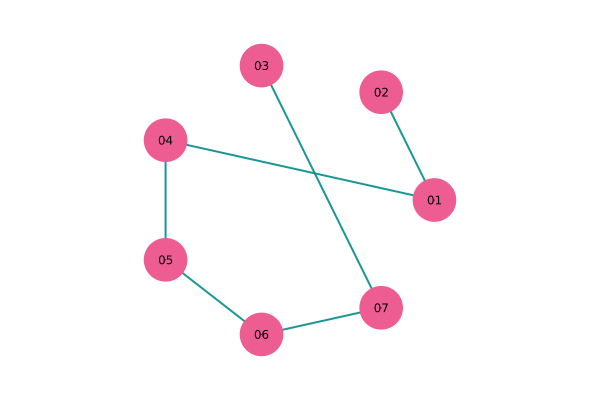

EXCITATION LEVEL: 1


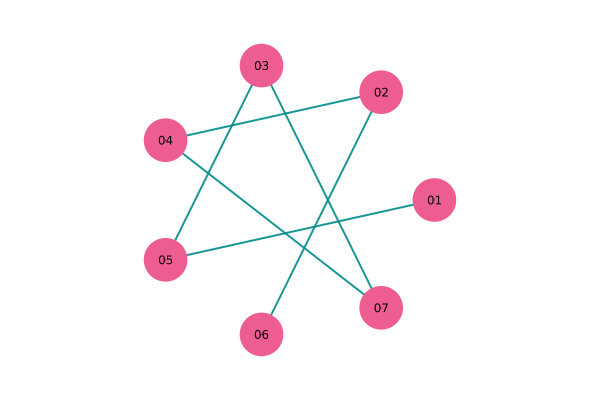

EXCITATION LEVEL: 2


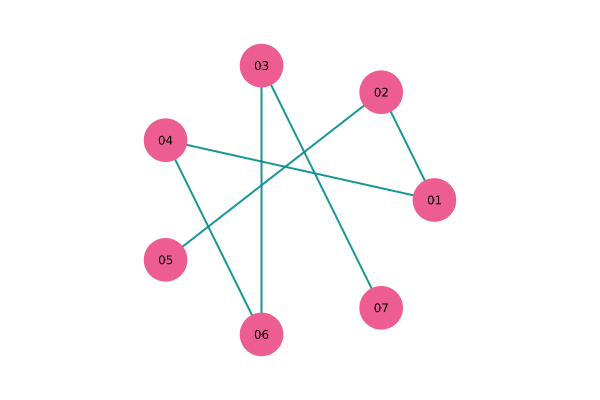

EXCITATION LEVEL: 3


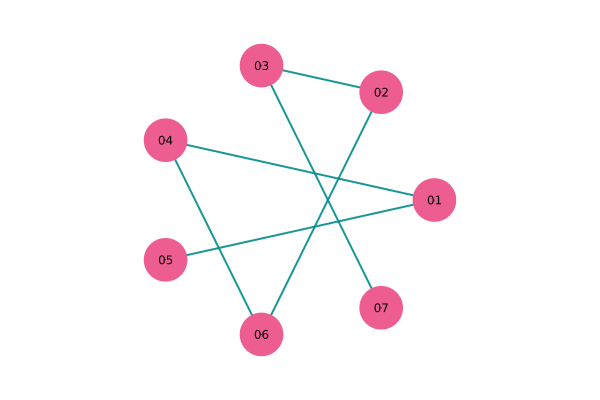

EXCITATION LEVEL: 4


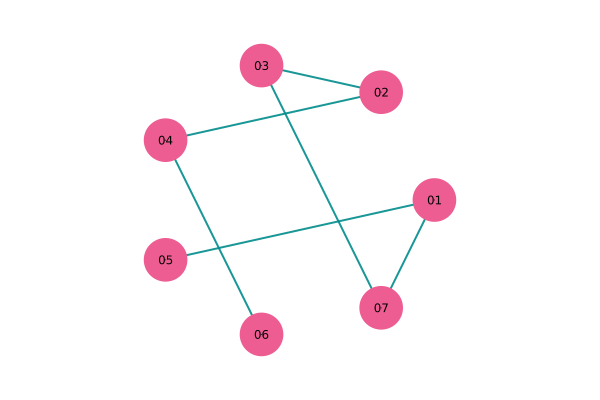

In [12]:
graph_mat_list = []

for (j,ord) in enumerate(tnqe0.ord_list)
    push!(graph_mat_list, GraphMat(ord, directed=false) )
end

for j=1:length(graph_mat_list)
    println("EXCITATION LEVEL: $(j-1)")
    OrbitalGraphPlot(graph_mat_list[j], multiplier=2.0)
end

In [16]:
#using Profile
#using ProfileVega

#Profile.clear()

tnqe1 = copy(tnqe0);
GenPermOps!(tnqe1, no_rev=false, verbose=false);
GenSubspaceMats!(tnqe1, verbose=false);
SolveGenEig!(tnqe1, thresh="inversion", eps=1e-8, verbose=true);


op1 = OptimParameters(
    maxiter=20, 
    numloop=12, 
    noise=[0.0], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="exp",
    alpha=2e4,
    restrict_svals=false,
    tethering=false,
    sweep=true,
    rnoise=1e-3,
    delta=1e-6
)

op2 = OptimParameters(
    maxiter=1, 
    numloop=18, 
    noise=[1e-6], 
    sd_thresh="inversion", 
    sd_eps=1.0e-6,
    afunc="flat",
    alpha=2e4,
    restrict_svals=true,
    sweep=true,
    delta=0.0,
    rnum=0
)

RandomSiteDecomp!(
    tnqe1, 
    op1, 
    verbose=true
)

RandomSiteDecomp!(
    tnqe1, 
    op2, 
    verbose=true
)

Minimum eigenvalue: -83.83433181597383
Condition number: 331613.6125093059
FCI energy: -75.01927599660624
Final energy estimate: -74.99331164696291
Best single ref. estimate: -74.99119489748426
Error: 0.025964349643331275
BSRfE: 0.02808109912197665
Improvement: 0.0021167494786453744
Percentage error reduction: 7.537986563313605
Eigenvalue condition numbers: [0.0119, 0.0121, 0.0122, 0.0123, 0.0124]
Percent correlation energy with single-geometry DMRG: 51.67168506793228
Percent correlation energy with multi-geometry TNQE: 55.31466695378743

RANDOM SITE DECOMPOSITION:
Iter: 20/20; loop: 12/12; E_min = -83.85667; kappa = 183.0; E_best = -83.85676; accept = 13/19 (68%)     
Done!


RANDOM SITE DECOMPOSITION:
Iter: 1/1; loop: 18/18; E_min = -83.85678; kappa = 642.0; E_best = -83.85676; accept = 0/0 (0%)     
Done!



Minimum eigenvalue: -83.85678131801318
Condition number: 641.6180303729012
FCI energy: -75.01927599660624
Final energy estimate: -75.01576114900226
Best single ref. estimate: -74.9880491125411
Error: 0.0035148476039807974
BSRfE: 0.031226884065134186
Improvement: 0.02771203646115339
Percentage error reduction: 88.74416161199625
Eigenvalue condition numbers: [0.0085, 0.0444, 0.0368, 0.6935, 1.5971]
Percent correlation energy with single-geometry DMRG: 46.25770590774716
Percent correlation energy with multi-geometry TNQE: 93.95085423097034


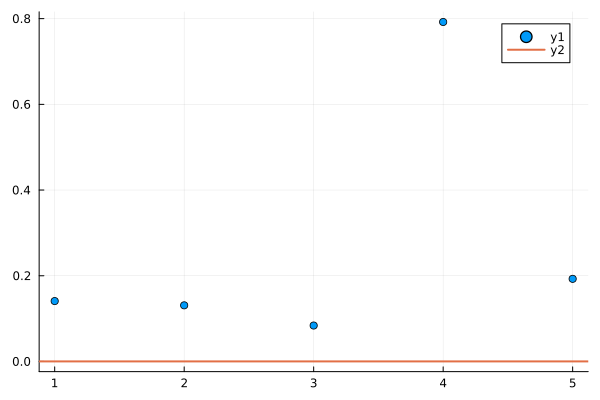

In [17]:
SolveGenEig!(tnqe1, thresh="none", verbose=true)